# 3DEP

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import py3dep
import pydaymet as daymet
import xarray as xr
from pynhd import NLDI

Py3DEP provides access to the [3DEP](https://www.usgs.gov/core-science-systems/ngp/3dep) database which is a part of the [National Map services](https://viewer.nationalmap.gov/services). The 3DEP service has multi-resolution sources and depending on the user provided resolution, the data is resampled on the server-side based on all the available data sources. Py3DEP returns the requests as xarray dataset. The 3DEP includes the following layers:

- DEM
- Hillshade Gray
- Aspect Degrees
- Aspect Map
- GreyHillshade Elevation Fill
- Hillshade Multidirectional
- Slope Map
- Slope Degrees
- Hillshade Elevation Tinted
- Height Ellipsoidal
- Contour 25
- Contour Smoothed 25

Moreover, Py3DEP offers some additional utilities:

- ``elevation_bygrid``: For getting elevations of all the grid points in a 2D grid.
- ``elevation_byloc``: For getting elevation of a single point which is based on the National Map's Elevation Point Query Service.
- ``deg2mpm``: For converting slope dataset from degree to meter per meter.

Let's get a watershed geometry using NLDI and then get DEM and slope.

In [2]:
geometry = NLDI().get_basins("01031500").geometry[0]

In [3]:
dem = py3dep.get_map(
    "DEM", geometry, resolution=30, geo_crs="epsg:4326", crs="epsg:3857"
)
dem.name = "dem"
dem.attrs["units"] = "meters"
slope = py3dep.get_map("Slope Degrees", geometry, resolution=30)
slope = py3dep.deg2mpm(slope)

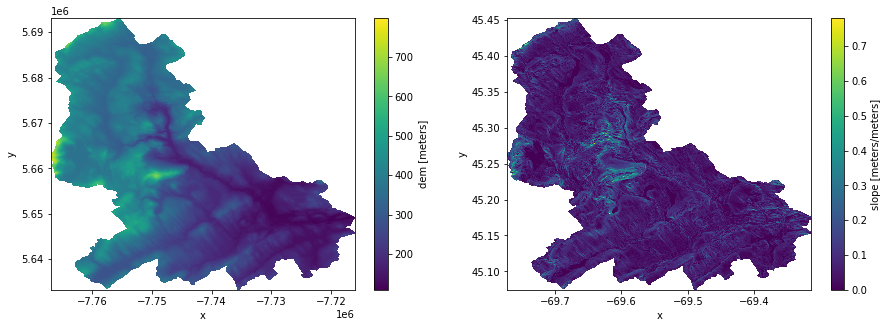

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dem.plot(ax=ax1)
slope.plot(ax=ax2);

We can get the elevation for a single point within the US in meters:

In [5]:
elev = py3dep.elevation_byloc((-7766049.665, 5691929.739), "epsg:3857")
elev

355.94

We can also get elevations of a list of coordinates using `py3dep.elevation_bycoords` function. This function is particularly useful for getting elevations of nodes of a network, for example, is a river or a street network. Let's use [osmnx](https://github.com/gboeing/osmnx) package to get a street network:

In [6]:
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")

Now, we can get the elevations for each node based on their coordinates and then plot the results.

In [7]:
x, y = nx.get_node_attributes(G, "x").values(), nx.get_node_attributes(G, "y").values()
elevation = py3dep.elevation_bycoords(list(zip(x, y)), crs="epsg:4326", resolution=90)
nx.set_node_attributes(G, dict(zip(G.nodes(), elevation)), "elevation")
G = ox.add_edge_grades(G)

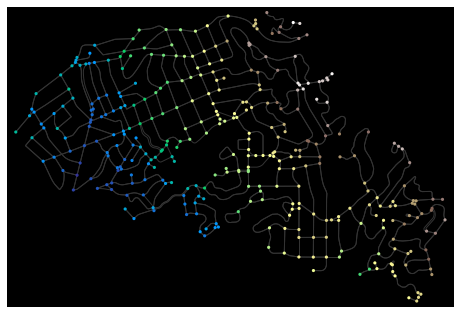

In [8]:
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="terrain")
fig, ax = ox.plot_graph(
    G, node_color=nc, node_size=10, edge_color="#333333", bgcolor="k"
)

Note that, this function gets the elevation data from the elevation map of the bounding box of all the coordinates. So, if the larger the extent of this bounding box, the longer is going to take for the function to get the data.

Additionally, we can get the elevations of set of x- and y- coordinates of a grid. For example,
let's get the minimum temperature data within the watershed from Daymet using [PyDaymet](https://github.com/cheginit/pydaymet) then add the elevation as a new variable to the dataset:

In [9]:
clm = daymet.get_bygeom(geometry, ("2005-01-01", "2005-01-31"), variables="tmin")
elev = py3dep.elevation_bygrid(clm.x.values, clm.y.values, clm.crs, clm.res[0] * 1000)
attrs = clm.attrs
clm = xr.merge([clm, elev])
clm["elevation"] = clm.elevation.where(~np.isnan(clm.isel(time=0).tmin), drop=True)
clm.attrs.update(attrs)

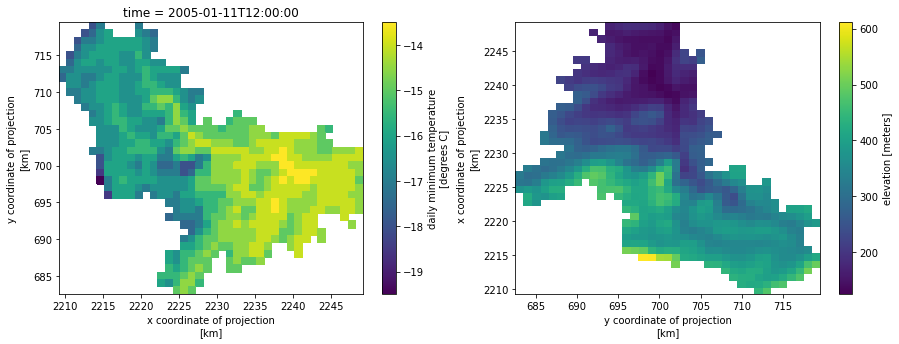

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
clm.tmin.isel(time=10).plot(ax=ax1)
clm.elevation.plot(ax=ax2);